In [ ]:
import numpy
import math
import copy
from matplotlib.path import Path

class Delaunay2d:

  EPS = 1.23456789e-14

  def __init__(self, points):

    # data structures
    self.points = points[:] # copy
    self.triangles = [] # cells
    self.edge2Triangles = {} # edge to triangle(s) map
    self.boundaryEdges = set()
    self.appliedBoundaryEdges = None
    self.holes = []


    # center of gravity
    cg = numpy.zeros((2,), numpy.float64)
    for pt in points:
      cg += pt
    cg /= len(points)

    # sort
    def distanceSquare(pt):
      d = pt - cg
      return numpy.dot(d, d)
    self.points.sort(key = distanceSquare)

    def getBoundaryEdges(triangles):
        edges = set()
        for tr in triangles:
            for i in range(3):
                edge = (tr[i], tr[(i+1)%3])
                if edge in edges:
                    edges.remove(edge)
                else:
                    edges.add(edge)
        return edges

    def getOuterBoundary(xyPoints, triangles):
      edges = getBoundaryEdges(triangles)
      outerBoundary = []
      for edge in edges:
          p1, p2 = xyPoints[edge[0]], xyPoints[edge[1]]
          if p1[0] < p2[0]:
              outerBoundary.append((p1, p2))
          else:
              outerBoundary.append((p2, p1))
      outerBoundary.sort(key=lambda x: x[0][0])
      return [p for e in outerBoundary for p in e]

    def removeHoles(xyPoints, triangles, holes):
      bad_triangles = []

      # Check each triangle to see if it is inside a hole
      for i, triangle in enumerate(triangles):
          isInsideHole = False
          for hole in holes:
              print("hole",hole)
              path = Path(hole)
              if path.contains_point(xyPoints[triangle[0]]) and \
                path.contains_point(xyPoints[triangle[1]]) and \
                path.contains_point(xyPoints[triangle[2]]):
                  isInsideHole = True
                  break
          if isInsideHole:
              bad_triangles.append(i)

      # Remove the bad triangles
      triangles = np.delete(triangles, bad_triangles, axis=0)

      return triangles

    # create first triangle
    area = 0.0
    index = 0
    stop = False
    while not stop and index + 2 < len(points):
      area = self.getArea(index, index + 1, index + 2)
      if abs(area) < self.EPS:
        del self.points[index]
      else:
        stop = True
    if index <= len(self.points) - 3:
      tri = [index, index + 1, index + 2]
      self.makeCounterClockwise(tri)
      self.triangles.append(tri)

      # boundary edges
      e01 = (tri[0], tri[1])
      self.boundaryEdges.add(e01)
      e12 = (tri[1], tri[2])
      self.boundaryEdges.add(e12)
      e20 = (tri[2], tri[0])
      self.boundaryEdges.add(e20)

      e01 = self.makeKey(e01[0], e01[1])
      self.edge2Triangles[e01] = [0,]

      e12 = self.makeKey(e12[0], e12[1])
      self.edge2Triangles[e12] = [0,]

      e20 = self.makeKey(e20[0], e20[1])
      self.edge2Triangles[e20] = [0,]

    else:
      return

    # add additional points
    for i in range(3, len(self.points)):
      self.addPoint(i)

    # remove all triangles inside holes
    self.triangles = removeHoles(self.points, self.triangles, self.holes)



  def getTriangles(self):
    return self.triangles

  def getEdges(self):
    return self.edge2Triangles.keys()

  def getArea(self, ip0, ip1, ip2):
    d1 = self.points[ip1] - self.points[ip0]
    d2 = self.points[ip2] - self.points[ip0]
    return (d1[0]*d2[1] - d1[1]*d2[0])

  def isEdgeVisible(self, ip, edge):
    area = self.getArea(ip, edge[0], edge[1])
    if area < self.EPS:
      return True
    return False

  def makeCounterClockwise(self, ips):
    area = self.getArea(ips[0], ips[1], ips[2])
    if area < -self.EPS:
      ip1, ip2 = ips[1], ips[2]
      # swap
      ips[1], ips[2] = ip2, ip1

  def flipOneEdge(self, edge):
    res = set()
    tris = self.edge2Triangles.get(edge, [])
    if len(tris) < 2:
        return res

    iTri1, iTri2 = tris
    tri1 = self.triangles[iTri1]
    tri2 = self.triangles[iTri2]

    # find the opposite vertices
    iOpposite1 = -1
    iOpposite2 = -1
    for i in range(3):
      if not tri1[i] in edge:
        iOpposite1 = tri1[i]
      if not tri2[i] in edge:
        iOpposite2 = tri2[i]

    # compute the 2 angles at the opposite vertices
    da1 = self.points[edge[0]] - self.points[iOpposite1]
    db1 = self.points[edge[1]] - self.points[iOpposite1]
    da2 = self.points[edge[0]] - self.points[iOpposite2]
    db2 = self.points[edge[1]] - self.points[iOpposite2]
    crossProd1 = self.getArea(iOpposite1, edge[0], edge[1])
    crossProd2 = self.getArea(iOpposite2, edge[1], edge[0])
    dotProd1 = numpy.dot(da1, db1)
    dotProd2 = numpy.dot(da2, db2)
    angle1 = abs(math.atan2(crossProd1, dotProd1))
    angle2 = abs(math.atan2(crossProd2, dotProd2))

    # Delaunay's test
    if angle1 + angle2 > math.pi*(1.0 + self.EPS):
      newTri1 = [iOpposite1, edge[0], iOpposite2] # triangle a
      newTri2 = [iOpposite1, iOpposite2, edge[1]] # triangle b

      # update the triangle
      self.triangles[iTri1] = newTri1
      self.triangles[iTri2] = newTri2

      del self.edge2Triangles[edge]

      # add new edge
      # the key is the edge and the value is a list of two triangle indices that share that edge.
      e = self.makeKey(iOpposite1, iOpposite2)
      self.edge2Triangles[e] = [iTri1, iTri2]

      # modify two edge entries which now connect to a different triangle
      e = self.makeKey(iOpposite1, edge[1])
      v = self.edge2Triangles[e]
      for i in range(len(v)):
        if v[i] == iTri1:
          v[i] = iTri2
      res.add(e)

      e = self.makeKey(iOpposite2, edge[0])
      v = self.edge2Triangles[e]
      for i in range(len(v)):
        if v[i] == iTri2:
          v[i] = iTri1
      res.add(e)

      res.add(self.makeKey(iOpposite1, edge[0]))
      res.add(self.makeKey(iOpposite2, edge[1]))

    return res

  def flipEdges(self):
    edgeSet = set(self.edge2Triangles.keys())
    continueFlipping = True
    while continueFlipping:
       #until no more edges to flip
      newEdgeSet = set()
      for edge in edgeSet:
        newEdgeSet.update(self.flipOneEdge(edge))

      edgeSet = copy.copy(newEdgeSet)
      continueFlipping = (len(edgeSet) > 0)

  def addPoint(self, ip):
    boundaryEdgesToRemove = set()
    boundaryEdgesToAdd = set()

    for edge in self.boundaryEdges:
      if self.isEdgeVisible(ip, edge):
        # create new triangle
        newTri = [edge[0], edge[1], ip]
        newTri.sort()
        self.makeCounterClockwise(newTri)
        self.triangles.append(newTri)

        # update the edge to triangle map
        e = list(edge[:])
        e.sort()
        iTri = len(self.triangles) - 1
        self.edge2Triangles[tuple(e)].append(iTri)

        # add the two boundary edges
        e1 = [ip, edge[0]]
        e1.sort()
        e1 = tuple(e1)
        e2 = [edge[1], ip]
        e2.sort()
        e2 = tuple(e2)
        v1 = self.edge2Triangles.get(e1, [])
        v1.append(iTri)
        v2 = self.edge2Triangles.get(e2, [])
        v2.append(iTri)
        self.edge2Triangles[e1] = v1
        self.edge2Triangles[e2] = v2

        # keep track of the boundary edges to update
        boundaryEdgesToRemove.add(edge)
        boundaryEdgesToAdd.add( (edge[0], ip) )
        boundaryEdgesToAdd.add( (ip, edge[1]) )

    # update the boundary edges
    for bedge in boundaryEdgesToRemove:
      self.boundaryEdges.remove(bedge)
    for bedge in boundaryEdgesToAdd:
      bEdgeSorted = list(bedge)
      bEdgeSorted.sort()
      bEdgeSorted = tuple(bEdgeSorted)
      if len(self.edge2Triangles[bEdgeSorted]) == 1:
        self.boundaryEdges.add(bedge)

    # recursively flip edges
    flipped = True
    while flipped:
      flipped = self.flipEdges()

  def makeKey(self, i1, i2):
    if i1 < i2:
      return (i1, i2)
    return (i2, i1)

In [ ]:
import random
import numpy as np
random.seed(1234)
xyPoints = [numpy.array([random.random(), random.random()]) for i in range(10)]
print(xyPoints)
xyPoints = [np.asarray([0,0]),np.asarray([0,1]),np.asarray([1,0]),np.asarray([1,1]), np.asarray([0,2]), np.asarray([2,0])]
np.asarray(xyPoints)

delaunay = Delaunay2d(xyPoints)
print(delaunay)
print(delaunay.getTriangles())
print(delaunay.getEdges())


[array([0.96645354, 0.4407326 ]), array([0.00749147, 0.91097596]), array([0.939269  , 0.58222757]), array([0.67156348, 0.08393823]), array([0.76648093, 0.23680978]), array([0.03081402, 0.78877272]), array([0.34608897, 0.62328148]), array([0.6158157 , 0.14855464]), array([0.18309065, 0.11441297]), array([0.01461878, 0.48675154])]
[[0 1 2]
 [1 3 2]
 [0 4 1]
 [1 3 4]
 [0 4 5]
 [0 2 5]
 [2 3 5]]
dict_keys([(0, 1), (1, 2), (0, 2), (1, 3), (2, 3), (0, 4), (1, 4), (3, 4), (0, 5), (4, 5), (2, 5), (3, 5)])


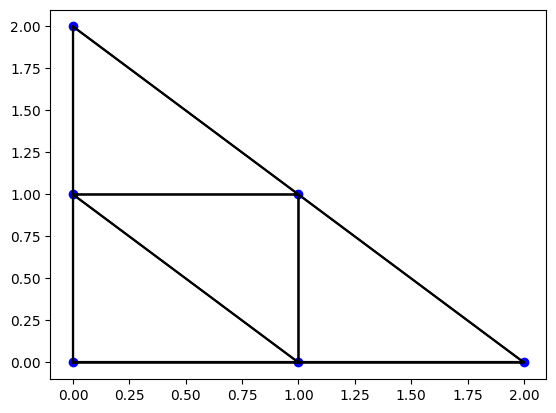

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_triangles(points, triangles):
    # Convert points to a NumPy array
    points = np.array(points)

    # Plot points
    plt.scatter(points[:, 0], points[:, 1], color='blue')

    # Plot triangles
    for triangle in triangles:
        x = [points[triangle[i], 0] for i in range(3)]
        y = [points[triangle[i], 1] for i in range(3)]
        plt.plot(x + [x[0]], y + [y[0]], color='black')

    plt.show()


def plot_Onlytriangles(triangles):
    plt.triplot(*zip(*sum(triangles, ())))
    plt.plot(*zip(*sum(triangles, ())))
    plt.show()

triangles = delaunay.getTriangles()
plot_triangles(xyPoints,triangles)


numPts 6


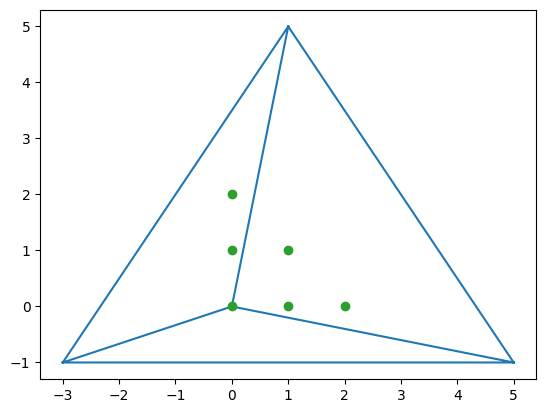

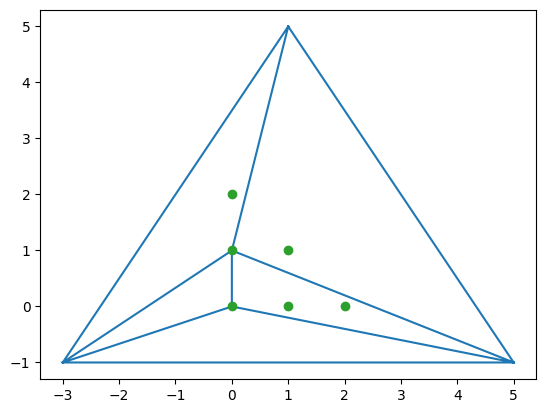

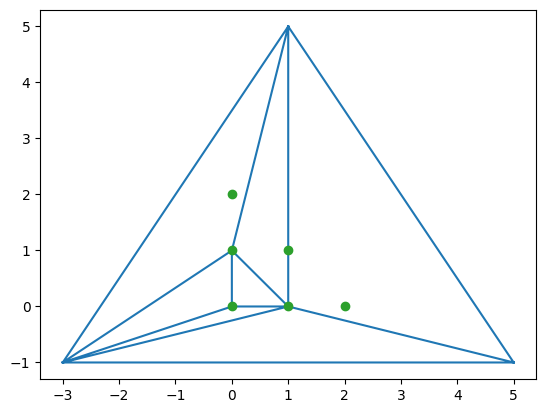

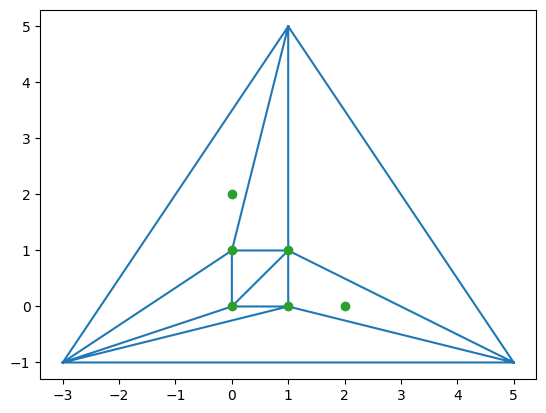

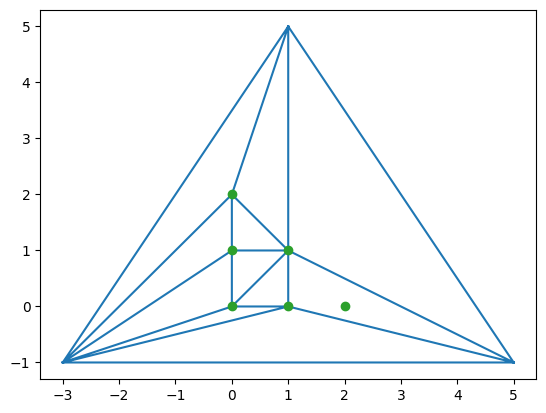

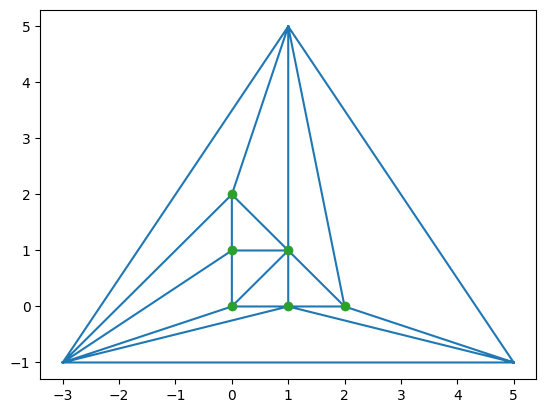

[]

In [ ]:
#Bowyer Watson algorithm
import numpy as np
import matplotlib.pyplot as plt
import random

EPS = 1.0e-14
# Define data structures
#points = points[:] # copy
points = [] # copy
triangles = [] # cells
edge2Triangles = {} # edge to triangle(s) map
boundaryEdges = set()
appliedBoundaryEdges = []
holes = []

# compute center of gravity
def GetCenterOfGravity(points):
    cg = np.zeros((2,), np.float64)
    for pt in points:
        cg += pt
    cg /= len(points)
    return cg

# sort
def distanceSquare(pt,cg):
    d = pt - cg
    return np.dot(d, d)
    #points.sort(key = distanceSquare)



def get_supertriangle(points):
    x_coords, y_coords = zip(*points)
    min_x, min_y = min(x_coords), min(y_coords)
    max_x, max_y = max(x_coords), max(y_coords)
    dx = max_x - min_x
    dy = max_y - min_y
    mid_x, mid_y = (min_x + max_x) / 2, (min_y + max_y) / 2
    return ((mid_x - 2*dx, mid_y - dy),
            (mid_x, mid_y + 2*dy),
            (mid_x + 2*dx, mid_y - dy))



def find_containing_triangle(point, triangulation):
    for triangle in triangulation:
        if point_in_triangle(point, triangle):
            return triangle

def calculate_circumcircle(triangle):
    (x1, y1), (x2, y2), (x3, y3) = triangle
    D = 2 * (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))
    x = ((x1**2 + y1**2)*(y2-y3) + (x2**2 + y2**2)*(y3-y1) + (x3**2 + y3**2)*(y1-y2)) / D
    y = ((x1**2 + y1**2)*(x3-x2) + (x2**2 + y2**2)*(x1-x3) + (x3**2 + y3**2)*(x2-x1)) / D
    radius = ((x1-x)**2 + (y1-y)**2)**0.5
    return (x, y), radius

def point_in_circumcircle(center,radius,triangle):
    x, y = center
    (x1, y1), (x2, y2), (x3, y3) = triangle
    dx1, dy1 = x1 - x, y1 - y
    dx2, dy2 = x2 - x, y2 - y
    dx3, dy3 = x3 - x, y3 - y
    a = dx1**2 + dy1**2
    b = dx2**2 + dy2**2
    c = dx3**2 + dy3**2
    determinant = (x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))**2
    return determinant > 0 and ((a*b*c)/(a*b + a*c + b*c)) < radius**2


    # Check if a triangle has an edge
def triangle_has_edge(triangle, edge):
    for i in range(3):
        if (triangle[i], triangle[(i+1)%3]) == edge or (triangle[(i+1)%3], triangle[i]) == edge:
            return True
    return False



def point_in_triangle(point, triangle):
    x1, y1 = triangle[0]
    x2, y2 = triangle[1]
    x3, y3 = triangle[2]
    x, y = point

    # Compute barycentric coordinates
    denom = (y2 - y3) * (x1 - x3) + (x3 - x2) * (y1 - y3)
    b1 = ((y2 - y3) * (x - x3) + (x3 - x2) * (y - y3)) / denom
    b2 = ((y3 - y1) * (x - x3) + (x1 - x3) * (y - y3)) / denom
    b3 = 1 - b1 - b2

    # Check if point is inside triangle
    return 0 <= b1 <= 1 and 0 <= b2 <= 1 and 0 <= b3 <= 1


def remove_duplicate_edges(edges):
     return list(set([tuple(sorted(e)) for e in edges]))

def make_counterclockwise(triangle):
    A, B, C = np.array(triangle)
    AB = B - A
    AC = C - A
    cross = np.cross(AB, AC)
    if cross < 0:
        return [A, C, B]
    else:
        return triangle

def triangles_intersect(triangle1, triangle2):
    # Plot the points and triangles
    #fig, ax = plt.subplots()
    # print("triangle1")
    # plt.triplot(*zip(*sum([triangle1], ())))
    # plt.show()
    # print("triangle2")
    # plt.triplot(*zip(*sum([triangle2], ())))
    # plt.show()
    # Convert tuples to numpy arrays
    triangle1=make_counterclockwise(triangle1)
    triangle2=make_counterclockwise(triangle2)
    A1, B1, C1 = np.array(triangle1)
    A2, B2, C2 = np.array(triangle2)

    A1 = np.append(A1, 0)
    A2 = np.append(A2, 0)
    B1 = np.append(B1, 0)
    B2 = np.append(B2, 0)
    C1 = np.append(C1, 0)
    C2 = np.append(C2, 0)
    # Compute the normal vectors of the planes of each triangle
    normal1 = np.cross(B1 - A1, C1 - A1)
    normal2 = np.cross(B2 - A2, C2 - A2)

    # Check if the triangles are parallel
    if np.allclose(normal1, np.zeros(3)) or np.allclose(normal2, np.zeros(3)):
        return False

    # Ensure the normal vectors are pointing outward
    if np.dot(normal1, A1 - A2) < 0:
        normal1 = -normal1
    if np.dot(normal2, A2 - A1) < 0:
        normal2 = -normal2

    # Compute the direction of the intersection line
    direction = np.cross(normal1, normal2)

    # Compute the intersection of the planes of the two triangles
    if np.allclose(direction, np.zeros(3)):
        return False
    x1, y1, z1 = A1
    x2, y2, z2 = A2
    t = np.dot(normal2, A2 - A1) / np.dot(normal1, normal2)
    intersection = np.array([x1, y1, z1]) + t * normal1

    # Check if the intersection point is inside both triangles
    if point_in_triangle(intersection, triangle1) and point_in_triangle(intersection, triangle2):
        return True
    else:
        return False


def lines_intersect(line1, line2):

    A1, B1 = line1
    A2, B2 = line2

    # Compute the direction vectors of the two lines
    dir1 = B1 - A1
    dir2 = B2 - A2

    # Compute the determinant of the matrix
    det = np.linalg.det([dir1, dir2])

    # If the determinant is zero, the lines are parallel and do not intersect
    if np.abs(det) < 1e-6:
        return False

    # Compute the intersection point of the two lines
    t1 = np.linalg.det([A2 - A1, dir2]) / det
    t2 = np.linalg.det([A2 - A1, dir1]) / det
    P = A1 + t1 * dir1

    # Check if the intersection point lies on both line segments
    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        return True

    # Otherwise, the line segments do not intersect
    return False

def remove_supertriangle(triangulation, supertriangle):
    # new_triangulation = []
    # print("supertriangle",supertriangle)
    # for triangle in triangulation:
    #   print("Newtriangle",triangle)
    #   # Check if any vertex of the triangle is in the supertriangle
    #   foundflag=False
    #   for vertex in supertriangle:
    #     print("supertrianglevertex",vertex)
    #     if vertex in triangle:
    #         found = True
    #         print("vertex",vertex)
    #         print("found")
    #         break
    #   if not found:
    #       new_triangulation.append(triangle)
    # # Remove any triangles that contain a vertex of the supertriangle
    triangles = [triangle for triangle in triangulation if not any(vertex in supertriangle for vertex in triangle)]

    return triangles



def delaunay_triangulation(points):
    print("numPts",len(points))
    # Add a supertriangle that contains all the points
    supertriangle = get_supertriangle(points)
    triangulation = [supertriangle]

    # Iterate over each input point and add it to the triangulation
    countPoint=0
    for point in points:
        # Find the containing triangle for the point
        containing_triangle = find_containing_triangle(point, triangulation)

        # If the point is outside the convex hull, skip it
        if containing_triangle is None:
            continue

        vertex1, vertex2, vertex3 = containing_triangle# Plot the triangle
        # plt.plot([vertex1[0], vertex2[0]], [vertex1[1], vertex2[1]], 'k-')
        # plt.plot([vertex2[0], vertex3[0]], [vertex2[1], vertex3[1]], 'k-')
        # plt.plot([vertex3[0], vertex1[0]], [vertex3[1], vertex1[1]], 'k-')
        # plt.show()

        # Create a new triangle by connecting the point to the vertices of the containing triangle
        new_triangle = (vertex1, vertex2, tuple(point))
        triangulation.append(new_triangle)

        # Plot the points and triangles
        plotxyPoints=np.asarray(points)
        fig, ax = plt.subplots()
        plt.triplot(*zip(*sum(triangulation, ())))
        ax.plot(plotxyPoints[:,0], plotxyPoints[:,1], 'o')
        plt.show()

        count=0
        countPoint+=1

        # Check if the new triangle intersects any other triangles
        to_check = [(vertex1, vertex2), (vertex2, vertex3), (vertex3, vertex1)]
        while to_check:
            edge = to_check.pop()
            for triangle in triangulation:
                count=count+1
                if triangle_has_edge(triangle, edge):
                    # If the edge is shared with another triangle, check if the new triangle intersects it
                    if triangles_intersect(triangle, new_triangle):
                        # If the new triangle does not intersect the existing triangle, add it to the set of Delaunay triangles
                        triangulation.remove(triangle)
                        to_check.extend([(triangle[i], triangle[(i+1)%3]) for i in range(3)])
                    break
            else:
                # If the edge is not shared with any other triangles, add it to the set of boundary edges
                boundaryEdges.add(edge)

    # Remove the supertriangle and any triangles that contain a vertex of the supertriangle
    triangles = remove_supertriangle(triangulation, supertriangle)

    # Remove any duplicate edges from the boundary
    boundary = remove_duplicate_edges(boundaryEdges)

    return triangles

random.seed(100)
xyPoints = [np.array([random.random(), random.random()]) for i in range(10)]
xyPoints = [np.asarray([0,0]),np.asarray([0,1]),np.asarray([1,0]),np.asarray([1,1]), np.asarray([0,2]), np.asarray([2,0])]
np.asarray(xyPoints)

delaunay_triangulation(xyPoints)



In [ ]:
import math

def delaunay_triangulation(points):
    # Add a supertriangle that contains all the points
    xmin = ymin = math.inf
    xmax = ymax = -math.inf
    for x, y in points:
        xmin = min(xmin, x)
        ymin = min(ymin, y)
        xmax = max(xmax, x)
        ymax = max(ymax, y)
    dx = xmax - xmin
    dy = ymax - ymin
    dmax = max(dx, dy)
    xmid = xmin + dx * 0.5
    ymid = ymin + dy * 0.5
    supertriangle = [
        (xmid - 20 * dmax, ymid - dmax),
        (xmid, ymid + 20 * dmax),
        (xmid + 20 * dmax, ymid - dmax)
    ]
    triangulation = [supertriangle]
    print("triangulation",triangulation)
    # Iterate over each input point and add it to the triangulation
    for point in points:
        # Find the containing triangle for the point
        containing_triangle = None
        for triangle in triangulation:
            if point_in_circumcircle(point, triangle):
                containing_triangle = triangle
                break
        print("containing_triangle",containing_triangle)
        # If the point is outside the convex hull, skip it
        if containing_triangle is None:
            continue

        # Create a new triangle by connecting the point to the vertices of the containing triangle
        vertex1, vertex2, vertex3 = containing_triangle
        new_triangle = (vertex1, vertex2, point)
        triangulation.append(new_triangle)
        new_triangle = (vertex2, vertex3, point)
        triangulation.append(new_triangle)
        new_triangle = (vertex3, vertex1, point)
        triangulation.append(new_triangle)

        # Remove any triangles that are no longer Delaunay after adding the new triangle
        bad_triangles = []
        for triangle in triangulation:
            if point_in_circumcircle(point, triangle):
                bad_triangles.append(triangle)
        triangulation = [triangle for triangle in triangulation if triangle not in bad_triangles]

    # Remove the supertriangle and any triangles that contain a vertex of the supertriangle
    triangles = [triangle for triangle in triangulation if not any(vertex in supertriangle for vertex in triangle)]

    return triangles


def point_in_circumcircle(point, triangle):
    ax, ay = triangle[0]
    bx, by = triangle[1]
    cx, cy = triangle[2]
    d = (ax - point[0]) * (by - point[1]) + (bx - point[0]) * (point[1] - ay) + (point[0] - cx) * (ay - by)
    if d > 0:
        return False
    u = ((point[0] - ax) ** 2 + (point[1] - ay) ** 2)
    v = ((point[0] - bx) ** 2 + (point[1] - by) ** 2)
    w = ((point[0] - cx) ** 2 + (point[1] - cy) ** 2)
    return (u * (bx * cy - cx * by) + v * (cx * ay - ax * cy) + w * (ax * by - bx * ay)) <= 0

xyPoints = [np.asarray([0,0]),np.asarray([0,1]),np.asarray([1,0]),np.asarray([1,1]), np.asarray([0,2]), np.asarray([2,0])]
np.asarray(xyPoints)
# delaunay = delaunay_triangulation(xyPoints)
# delaunay.show()

triangles = delaunay_triangulation(xyPoints)
print("triangles",triangles)

triangulation [[(-39.0, -1.0), (1.0, 41.0), (41.0, -1.0)]]
containing_triangle None
containing_triangle None
containing_triangle None
containing_triangle None
containing_triangle None
containing_triangle [(-39.0, -1.0), (1.0, 41.0), (41.0, -1.0)]
triangles []


Without class

In [ ]:
import numpy as np

x = np.array([1, 2, 0])
y = np.array([4, 5, 0])
z = np.array([0, 0, 1])

normal = np.cross(x, y)  # compute cross product of x and y
print("normal",normal)

normal [ 0  0 -3]


In [ ]:
def makeCounterClockwise(self, ips):
    """
    Re-order nodes to ensure positive area (in-place operation)
    """
    area = self.getArea(ips[0], ips[1], ips[2])
    if area < -self.EPS:
      ip1, ip2 = ips[1], ips[2]
      # swap
      ips[1], ips[2] = ip2, ip1

def getArea(self, ip0, ip1, ip2):
    """
    Compute the parallelipiped area
    @param ip0 index of first vertex
    @param ip1 index of second vertex
    @param ip2 index of third vertex
    """
    d1 = self.points[ip1] - self.points[ip0]
    d2 = self.points[ip2] - self.points[ip0]
    return (d1[0]*d2[1] - d1[1]*d2[0])

def makeKey(self, i1, i2):
    """
    Make a tuple key such at i1 < i2
    """
    if i1 < i2:
      return (i1, i2)
    return (i2, i1)

def addPoint(self, ip):
    """
    Add point
    @param ip point index
    """

    # collection for later updates
    boundaryEdgesToRemove = set()
    boundaryEdgesToAdd = set()

    for edge in self.boundaryEdges:

      if self.isEdgeVisible(ip, edge):

        # create new triangle
        newTri = [edge[0], edge[1], ip]
        newTri.sort()
        self.makeCounterClockwise(newTri)
        self.triangles.append(newTri)

        # update the edge to triangle map
        e = list(edge[:])
        e.sort()
        iTri = len(self.triangles) - 1
        self.edge2Triangles[tuple(e)].append(iTri)

        # add the two boundary edges
        e1 = [ip, edge[0]]
        e1.sort()
        e1 = tuple(e1)
        e2 = [edge[1], ip]
        e2.sort()
        e2 = tuple(e2)
        v1 = self.edge2Triangles.get(e1, [])
        v1.append(iTri)
        v2 = self.edge2Triangles.get(e2, [])
        v2.append(iTri)
        self.edge2Triangles[e1] = v1
        self.edge2Triangles[e2] = v2

        # keep track of the boundary edges to update
        boundaryEdgesToRemove.add(edge)
        boundaryEdgesToAdd.add( (edge[0], ip) )
        boundaryEdgesToAdd.add( (ip, edge[1]) )

    # update the boundary edges
    for bedge in boundaryEdgesToRemove:
      self.boundaryEdges.remove(bedge)
    for bedge in boundaryEdgesToAdd:
      bEdgeSorted = list(bedge)
      bEdgeSorted.sort()
      bEdgeSorted = tuple(bEdgeSorted)
      if len(self.edge2Triangles[bEdgeSorted]) == 1:
        # only add boundary edge if it does not appear
        # twice in different order
        self.boundaryEdges.add(bedge)


    # recursively flip edges
    flipped = True
    while flipped:
      flipped = self.flipEdges()

def getOuterBoundary(xyPoints, triangles):
      edges = getBoundaryEdges(triangles)
      outerBoundary = []
      for edge in edges:
          p1, p2 = xyPoints[edge[0]], xyPoints[edge[1]]
          if p1[0] < p2[0]:
              outerBoundary.append((p1, p2))
          else:
              outerBoundary.append((p2, p1))
      outerBoundary.sort(key=lambda x: x[0][0])
      return [p for e in outerBoundary for p in e]

def removeHoles(xyPoints, triangles, holes):
  # Create a list to store the triangles that are inside a hole
  bad_triangles = []

  # Check each triangle to see if it is inside a hole
  for i, triangle in enumerate(triangles):
      isInsideHole = False
      for hole in holes:
          print("hole",hole)
          path = Path(hole)
          if path.contains_point(xyPoints[triangle[0]]) and \
            path.contains_point(xyPoints[triangle[1]]) and \
            path.contains_point(xyPoints[triangle[2]]):
              isInsideHole = True
              break
      if isInsideHole:
          bad_triangles.append(i)

  # Remove the bad triangles
  triangles = np.delete(triangles, bad_triangles, axis=0)

  return triangles

def getBoundaryEdges(triangles):
        edges = set()
        for tr in triangles:
            for i in range(3):
                edge = (tr[i], tr[(i+1)%3])
                if edge in edges:
                    edges.remove(edge)
                else:
                    edges.add(edge)
        return edges

In [ ]:
import numpy
import random
random.seed(1234)
xyPoints = [numpy.array([random.random(), random.random()]) for i in range(10)]
print(xyPoints)
#xyPoints = [np.asarray([0,0]),np.asarray([0,1]),np.asarray([1,0]),np.asarray([1,1]), np.asarray([0,2]), np.asarray([2,0])]
np.asarray(xyPoints)
xyPoints = sorted(xyPoints, key=lambda p: (p[0], p[1]))

EPS = 1.0e-14
# Define data structures
#points = points[:] # copy
points = xyPoints # copy
triangles = [] # cells
edge2Triangles = {} # edge to triangle(s) map
boundaryEdges = set()
appliedBoundaryEdges = None
holes = []


# create first triangle, make sure we're getting a non-zero area otherwise
# drop the points
area = 0.0
index = 0
stop = False
while not stop and index + 2 < len(points):
  area = getArea(index, index + 1, index + 2)
  if abs(area) < EPS:
    del points[index]
  else:
    stop = True
if index <= len(points) - 3:
  tri = [index, index + 1, index + 2]
  makeCounterClockwise(tri)
  triangles.append(tri)

  # boundary edges
  e01 = (tri[0], tri[1])
  boundaryEdges.add(e01)
  e12 = (tri[1], tri[2])
  boundaryEdges.add(e12)
  e20 = (tri[2], tri[0])
  boundaryEdges.add(e20)

  e01 = makeKey(e01[0], e01[1])
  edge2Triangles[e01] = [0,]

  e12 = makeKey(e12[0], e12[1])
  edge2Triangles[e12] = [0,]

  e20 = makeKey(e20[0], e20[1])
  edge2Triangles[e20] = [0,]


# add additional points
for i in range(3, len(points)):
  addPoint(i)

# remove all triangles inside holes
# TO DO

outerBoundary = getOuterBoundary(points, triangles)
holes.append(outerBoundary)
triangles = removeHoles(points, triangles, holes)



[array([0.96645354, 0.4407326 ]), array([0.00749147, 0.91097596]), array([0.939269  , 0.58222757]), array([0.67156348, 0.08393823]), array([0.76648093, 0.23680978]), array([0.03081402, 0.78877272]), array([0.34608897, 0.62328148]), array([0.6158157 , 0.14855464]), array([0.18309065, 0.11441297]), array([0.01461878, 0.48675154])]


TypeError: ignored

In [ ]:
print(triangles)

[]
